In [1]:
### General ###
import os
import sys
import copy
from tqdm import tqdm
import pickle
import random
import warnings
warnings.filterwarnings("ignore")

### Data Wrangling ###
import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime, timedelta

### Data Visualization ###
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

### Machine Learning ###
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import VarianceThreshold, RFE, SelectPercentile
from sklearn.model_selection import cross_val_score
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import lightgbm as lgb
import xgboost as xgb

### Deep Learning ###
import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F
from torch.nn.modules.loss import _WeightedLoss
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Tabnet 
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetRegressor

# 한글 폰트 설정
from statsmodels import robust
from matplotlib import font_manager, rc
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

In [2]:
# 데이터 불러오기
train = pd.read_csv('data/trainset.csv')
test = pd.read_csv('data/testset_final.csv')

# susbmssion
submission = pd.read_csv('data/sample_submission_final.csv')

In [3]:
train = train.drop(['매니저주소', '매니저최초가입일', '매니저최초서비스일'], axis=1)

In [4]:
train.shape, test.shape, submission.shape

((23009, 30), (4244, 29), (4244, 2))

In [5]:
train.head(1)

,SEQ,접수일,접수시각,장기서비스여부,최초서비스일,전체회차,현재회차,서비스일자,서비스시작시간,서비스종료시간,...,매니저생년월일,매니저성별,매니저사용휴대폰,매니저이동방법,근무가능지역,CS교육이수여부,청소교육이수여부,부재중서비스가능여부,추천인여부,매칭성공여부
0,T06420,2019-07-09,NaN,1,2019-07-15,3,3,2019-07-29,9:00:00,13:00:00,...,1956-04-19,0,안드로이드,대중교통,서울,0.0,0.0,1,0,0


In [6]:
submission.head(1)

,SEQ,pred
0,T54370,0.5


## 기본 전처리 및 EDA

In [7]:
# 날짜 처리
train['접수일'] = pd.to_datetime(train['접수일'])
train['최초서비스일'] = pd.to_datetime(train['최초서비스일'])
train['서비스일자'] = pd.to_datetime(train['서비스일자'])
train['고객가입일'] = pd.to_datetime(train['고객가입일'])
train['매니저생년월일'] = pd.to_datetime(train['매니저생년월일']).dt.year

# 시간 처리
train['서비스시작시간'] = pd.to_datetime(train['서비스시작시간'], format='%H:%M:%S')
train['서비스종료시간'] = pd.to_datetime(train['서비스종료시간'], format='%H:%M:%S')
train['서비스시작시간'] = train['서비스시작시간'].dt.hour
train['서비스종료시간'] = train['서비스종료시간'].dt.hour

# 날짜 처리
test['접수일'] = pd.to_datetime(test['접수일'])
test['최초서비스일'] = pd.to_datetime(test['최초서비스일'])
test['서비스일자'] = pd.to_datetime(test['서비스일자'])
test['고객가입일'] = pd.to_datetime(test['고객가입일'])
#test['매니저생년월일'] = pd.to_datetime(test['매니저생년월일'])

# 시간 처리
test['서비스시작시간'] = pd.to_datetime(test['서비스시작시간'], format='%H:%M:%S')
test['서비스종료시간'] = pd.to_datetime(test['서비스종료시간'], format='%H:%M:%S')
test['서비스시작시간'] = test['서비스시작시간'].dt.hour
test['서비스종료시간'] = test['서비스종료시간'].dt.hour

In [8]:
# 접수일 기준
train['접수일_월'] = train['접수일'].dt.month
train['접수일_주차'] = train['접수일'].dt.week
train['접수일_일'] = train['접수일'].dt.day
train['접수일_요일'] = train['접수일'].dt.dayofweek

test['접수일_월'] = test['접수일'].dt.month
test['접수일_주차'] = test['접수일'].dt.week
test['접수일_일'] = test['접수일'].dt.day
test['접수일_요일'] = test['접수일'].dt.dayofweek

# 서비스일자 기준
train['서비스일자_월'] = train['서비스일자'].dt.month
train['서비스일자_주차'] = train['서비스일자'].dt.week
train['서비스일자_일'] = train['서비스일자'].dt.day
train['서비스일자_요일'] = train['서비스일자'].dt.dayofweek

test['서비스일자_월'] = test['서비스일자'].dt.month
test['서비스일자_주차'] = test['서비스일자'].dt.week
test['서비스일자_일'] = test['서비스일자'].dt.day
test['서비스일자_요일'] = test['서비스일자'].dt.dayofweek

In [9]:
train['접수일_month_group'] = pd.cut(train['접수일_일'], bins = [1, 10, 20, 32], 
                              right = False, labels = ['Cho', 'Jung', 'Mal'])
train['서비스일자_month_group'] = pd.cut(train['서비스일자_일'], bins = [1, 10, 20, 32], 
                              right = False, labels = ['Cho', 'Jung', 'Mal'])

test['접수일_month_group'] = pd.cut(test['접수일_일'], bins = [1, 10, 20, 32], 
                              right = False, labels = ['Cho', 'Jung', 'Mal'])
test['서비스일자_month_group'] = pd.cut(test['서비스일자_일'], bins = [1, 10, 20, 32], 
                              right = False, labels = ['Cho', 'Jung', 'Mal'])

In [10]:
train['접수일_fire여부'] = train['접수일_요일'].apply(lambda x : 1 if x >= 4 else 0)
test['접수일_fire여부'] = test['접수일_요일'].apply(lambda x : 1 if x >= 4 else 0)

train['서비스일자_fire여부'] = train['서비스일자_요일'].apply(lambda x : 1 if x >= 4 else 0)
test['서비스일자_fire여부'] = test['서비스일자_요일'].apply(lambda x : 1 if x >= 4 else 0)

In [11]:
train['시작_시간대'] = train['서비스시작시간'].apply(lambda x : '아침' if (x>=7) and (x<=11)
                                               else '점심' if (x>11) and (x<=13)
                                               else '오후' if (x>13) and (x<=19)
                                               else '밤')
test['시작_시간대'] = test['서비스시작시간'].apply(lambda x : '아침' if (x>=7) and (x<=11)
                                               else '점심' if (x>11) and (x<=13)
                                               else '오후' if (x>13) and (x<=19)
                                               else '밤')

train['종료_시간대'] = train['서비스종료시간'].apply(lambda x : '아침' if (x>=7) and (x<=11)
                                               else '점심' if (x>11) and (x<=13)
                                               else '오후' if (x>13) and (x<=19)
                                               else '밤')
test['종료_시간대'] = test['서비스종료시간'].apply(lambda x : '아침' if (x>=7) and (x<=11)
                                               else '점심' if (x>11) and (x<=13)
                                               else '오후' if (x>13) and (x<=19)
                                               else '밤')

In [12]:
train['반려동물'] = train['반려동물'].apply(lambda x: 0 if x=='없음' else 1 
                                    if x in ['개', '고양이', '기타', '개,고양이', '고양이,기타', '개,기타'] else x)
test['반려동물'] = test['반려동물'].apply(lambda x: 0 if x=='없음' else 1 
                                  if x in ['개', '고양이', '기타', '개,고양이', '고양이,기타', '개,기타'] else x)

In [13]:
train.iloc[:, :20].head(1)

,SEQ,접수일,접수시각,장기서비스여부,최초서비스일,전체회차,현재회차,서비스일자,서비스시작시간,서비스종료시간,기존고객여부,결재형태,서비스주소,주거형태,평수,고객가입일,반려동물,부재중여부,우선청소,쿠폰사용여부
0,T06420,2019-07-09,NaN,1,2019-07-15,3,3,2019-07-29,9,13,1,무통장입금,충남 천안시,일반주택,NaN,2019-04-22,NaN,NaN,NaN,0


In [14]:
train.iloc[:, 20:40].head(1)

,매니저생년월일,매니저성별,매니저사용휴대폰,매니저이동방법,근무가능지역,CS교육이수여부,청소교육이수여부,부재중서비스가능여부,추천인여부,매칭성공여부,접수일_월,접수일_주차,접수일_일,접수일_요일,서비스일자_월,서비스일자_주차,서비스일자_일,서비스일자_요일,접수일_month_group,서비스일자_month_group
0,1956,0,안드로이드,대중교통,서울,0.0,0.0,1,0,0,7,28,9,1,7,31,29,0,Cho,Mal


In [15]:
train.iloc[:, 40:].head(1)

,접수일_fire여부,서비스일자_fire여부,시작_시간대,종료_시간대
0,0,0,아침,점심


In [16]:
train.isnull().sum()

SEQ                      0
접수일                      0
접수시각                 19896
장기서비스여부                  0
최초서비스일                   0
전체회차                     0
현재회차                     0
서비스일자                    0
서비스시작시간                  0
서비스종료시간                  0
기존고객여부                   0
결재형태                     0
서비스주소                    0
주거형태                     0
평수                    9153
고객가입일                    0
반려동물                  2775
부재중여부                 9153
우선청소                 12030
쿠폰사용여부                   0
매니저생년월일                  0
매니저성별                    0
매니저사용휴대폰              2799
매니저이동방법                250
근무가능지역                   0
CS교육이수여부              2799
청소교육이수여부              2799
부재중서비스가능여부               0
추천인여부                    0
매칭성공여부                   0
접수일_월                    0
접수일_주차                   0
접수일_일                    0
접수일_요일                   0
서비스일자_월                  0
서비스일자_주차                 0
서비스일자_일                  0
서

## feature 생성

In [17]:
train['서비스소요시간'] = train['서비스종료시간'] - train['서비스시작시간']
train['회차사용비율'] = train['현재회차'] / train['전체회차']
train['남은회차'] = train['전체회차'] - train['현재회차']

# 기간 관련 피처
#train['접수일기준_고객가입기간'] = train['접수일'] - train['고객가입일']
train['접수후최초서비스걸린시일'] = train['최초서비스일'] - train['접수일']
train['접수후서비스걸린시일'] = train['서비스일자'] - train['접수일']
train['최초서비스_서비스_시일'] = train['서비스일자'] - train['최초서비스일']

In [18]:
test['서비스소요시간'] = test['서비스종료시간'] - test['서비스시작시간']
test['회차사용비율'] = test['현재회차'] / test['전체회차']
test['남은회차'] = test['전체회차'] - test['현재회차']

# 기간 관련 피처
#test['접수일기준_고객가입기간'] = test['접수일'] - test['고객가입일']
test['접수후최초서비스걸린시일'] = test['최초서비스일'] - test['접수일']
test['접수후서비스걸린시일'] = test['서비스일자'] - test['접수일']
test['최초서비스_서비스_시일'] = test['서비스일자'] - test['최초서비스일']

In [19]:
# timedelta 형식 feature -> int형식으로
#train['접수일기준_고객가입기간'] = train['접수일기준_고객가입기간'].dt.days.astype('int16')
train['접수후최초서비스걸린시일'] = train['접수후최초서비스걸린시일'].dt.days.astype('int16')
train['접수후서비스걸린시일'] = train['접수후서비스걸린시일'].dt.days.astype('int16')
train['최초서비스_서비스_시일'] = train['최초서비스_서비스_시일'].dt.days.astype('int16')

#test['접수일기준_고객가입기간'] = test['접수일기준_고객가입기간'].dt.days.astype('int16')
test['접수후최초서비스걸린시일'] = test['접수후최초서비스걸린시일'].dt.days.astype('int16')
test['접수후서비스걸린시일'] = test['접수후서비스걸린시일'].dt.days.astype('int16')
test['최초서비스_서비스_시일'] = test['최초서비스_서비스_시일'].dt.days.astype('int16')

In [20]:
# 시간 추가 여부
train['시간추가여부'] = train['서비스소요시간'].apply(lambda x : 0 if x in [2, 4, 6, 8] else 1)
test['시간추가여부'] = test['서비스소요시간'].apply(lambda x : 0 if x in [2, 4, 6, 8] else 1)

In [21]:
train['시간비율'] = train['서비스시작시간'] / train['서비스종료시간']
test['시간비율'] = test['서비스시작시간'] / test['서비스종료시간']

In [22]:
# 매니저 나이
train['매니저나이'] = train['매니저생년월일'].apply(lambda x : 2021 - x)
test['매니저나이'] = test['매니저생년월일'].apply(lambda x : 2021 - x)

In [23]:
#고객 열만~ 
na_sum = []
for i in range (0, train.shape[0], 1):
    na_all = train.iloc[i:i+1, 3:20].isna().sum().sum()
    na_sum.append(na_all)

In [24]:
na_sum_te = []
for i in range (0, test.shape[0], 1):
    na_all = test.iloc[i:i+1, 3:20].isna().sum().sum()
    na_sum_te.append(na_all)

In [25]:
na_df = pd.DataFrame(na_sum)
na_df.columns = ['na값']

In [26]:
na_df_te = pd.DataFrame(na_sum_te)
na_df_te.columns = ['na값']

In [27]:
train = pd.concat([train, na_df], axis=1)
test = pd.concat([test, na_df_te], axis=1)

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23009 entries, 0 to 23008
Data columns (total 54 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   SEQ                23009 non-null  object        
 1   접수일                23009 non-null  datetime64[ns]
 2   접수시각               3113 non-null   object        
 3   장기서비스여부            23009 non-null  int64         
 4   최초서비스일             23009 non-null  datetime64[ns]
 5   전체회차               23009 non-null  int64         
 6   현재회차               23009 non-null  int64         
 7   서비스일자              23009 non-null  datetime64[ns]
 8   서비스시작시간            23009 non-null  int64         
 9   서비스종료시간            23009 non-null  int64         
 10  기존고객여부             23009 non-null  int64         
 11  결재형태               23009 non-null  object        
 12  서비스주소              23009 non-null  object        
 13  주거형태               23009 non-null  object        
 14  평수    

## 데이터 셋 세팅

In [29]:
train.columns

Index(['SEQ', '접수일', '접수시각', '장기서비스여부', '최초서비스일', '전체회차', '현재회차', '서비스일자',
       '서비스시작시간', '서비스종료시간', '기존고객여부', '결재형태', '서비스주소', '주거형태', '평수', '고객가입일',
       '반려동물', '부재중여부', '우선청소', '쿠폰사용여부', '매니저생년월일', '매니저성별', '매니저사용휴대폰',
       '매니저이동방법', '근무가능지역', 'CS교육이수여부', '청소교육이수여부', '부재중서비스가능여부', '추천인여부',
       '매칭성공여부', '접수일_월', '접수일_주차', '접수일_일', '접수일_요일', '서비스일자_월', '서비스일자_주차',
       '서비스일자_일', '서비스일자_요일', '접수일_month_group', '서비스일자_month_group',
       '접수일_fire여부', '서비스일자_fire여부', '시작_시간대', '종료_시간대', '서비스소요시간', '회차사용비율',
       '남은회차', '접수후최초서비스걸린시일', '접수후서비스걸린시일', '최초서비스_서비스_시일', '시간추가여부', '시간비율',
       '매니저나이', 'na값'],
      dtype='object')

In [30]:
features = ['장기서비스여부', '전체회차', '현재회차', '서비스시작시간', '서비스종료시간', '기존고객여부', '결재형태', 
            '서비스주소', '주거형태', '평수', '반려동물', '부재중여부', '우선청소', '쿠폰사용여부', 
            '매니저사용휴대폰', '매니저이동방법', '근무가능지역', 'CS교육이수여부', 
            '청소교육이수여부', '부재중서비스가능여부', '추천인여부', '접수일_월', '접수일_주차', '접수일_일', 
            '접수일_요일', '서비스일자_월', '서비스일자_주차', '서비스일자_일', '서비스일자_요일', '접수일_month_group', 
            '서비스일자_month_group', '접수일_fire여부', '서비스일자_fire여부', '시작_시간대', '종료_시간대', '서비스소요시간', 
            '회차사용비율', '남은회차', '접수후최초서비스걸린시일', '접수후서비스걸린시일', '최초서비스_서비스_시일', 
            '시간추가여부', '시간비율', '매니저나이', 'na값']

In [31]:
ftr = train[features]
ftr_te = test[features]
target = train['매칭성공여부']

In [32]:
ftr.isnull().sum()

장기서비스여부                  0
전체회차                     0
현재회차                     0
서비스시작시간                  0
서비스종료시간                  0
기존고객여부                   0
결재형태                     0
서비스주소                    0
주거형태                     0
평수                    9153
반려동물                  2775
부재중여부                 9153
우선청소                 12030
쿠폰사용여부                   0
매니저사용휴대폰              2799
매니저이동방법                250
근무가능지역                   0
CS교육이수여부              2799
청소교육이수여부              2799
부재중서비스가능여부               0
추천인여부                    0
접수일_월                    0
접수일_주차                   0
접수일_일                    0
접수일_요일                   0
서비스일자_월                  0
서비스일자_주차                 0
서비스일자_일                  0
서비스일자_요일                 0
접수일_month_group          0
서비스일자_month_group        0
접수일_fire여부               0
서비스일자_fire여부             0
시작_시간대                   0
종료_시간대                   0
서비스소요시간                  0
회차사용비율                   0
남

## 결측치 처리

In [33]:
# 반려동물: 결측치 비율이 12%이지만, 대부분이 '없음'(없음 > 개 > 고양이 > 기타) -> '대체?
# 매니저사용휴대폰: 결측치 비율이 12%이며, 대부분이 '안드로이드' (안드로이드 > 기타 > ios) -> 최빈값인 '안드로이드'로 대체? or '기타'로 대체? 
# 매니저이동방법: 결측치 비율이 1%이며, 대부분이 '대중교통'이므로 최빈값인 '대중교통'으로 대체!
# CS교육이수여부: 결측치 비율이 12%이며, 대부분이 '미이수'이므로 최빈값인 '미이수'로 대체!
# 청소교육이수여부: 결측치 비율이 12%이며, 대부분이 '미이수'이므로 최빈값인 '미이수'로 대체!

imputer_col = ['반려동물']#, '매니저사용휴대폰', '매니저이동방법', 'CS교육이수여부', '청소교육이수여부']

for col in imputer_col:
    ftr.loc[ftr[col].isna(), col] = ftr[col].mode()[0]
    ftr_te.loc[ftr_te[col].isna(), col] = ftr_te[col].mode()[0]

In [34]:
### train, test셋의 구성이 다른 피처 처리
print(set(train['결재형태'].unique()) - set(test['결재형태'].unique()))
print(set(test['결재형태'].unique()) - set(train['결재형태'].unique()))

# 앞에 두글자만 따던지 해야할듯
print(set(train['서비스주소'].unique()) - set(test['서비스주소'].unique()))
print(set(test['서비스주소'].unique()) - set(train['서비스주소'].unique()))

{'미수'}
{nan}
{'부산 동래구', '경남 창원시'}
{'경기 화성시', '부산 부산진구', '서울 광진구', '서울 송파구', '부산 북구', '부산 금정구', '부산 사상구'}


In [35]:
# train, test셋의 구성이 다른 피처 처리 - 결제형태, 서비스주소
ftr['서비스주소'] = ftr.서비스주소.str[:2]
ftr['결재형태'] = ftr.결재형태.replace('미수', np.NaN) # or 드랍 
                               
ftr_te['서비스주소'] = ftr_te.서비스주소.str[:2]
ftr_te['결재형태'] = ftr_te.결재형태.replace('미수', np.NaN) # or 드랍 

In [36]:
# 한글로 구성되어 있는 피처 Label Encoding
from sklearn.preprocessing import LabelEncoder
lst = ['주거형태', '평수', '우선청소', '매니저사용휴대폰', '매니저이동방법', '근무가능지역', '서비스주소', '결재형태', 
       'CS교육이수여부', '청소교육이수여부', '접수일_month_group', '서비스일자_month_group', '시작_시간대', '종료_시간대']

for i in lst:
    le = LabelEncoder()
    ftr[i] = le.fit_transform(ftr[i])
    ftr_te[i] = le.transform(ftr_te[i])

In [37]:
ftr['평수'] = ftr.평수.replace(4, np.NaN)
ftr['우선청소'] = ftr.우선청소.replace(5, np.NaN)
ftr['매니저사용휴대폰'] = ftr.매니저사용휴대폰.replace(3, np.NaN)
ftr['매니저이동방법'] = ftr.매니저이동방법.replace(2, np.NaN)
ftr['CS교육이수여부'] = ftr.CS교육이수여부.replace(2, np.NaN)
ftr['청소교육이수여부'] = ftr.청소교육이수여부.replace(2, np.NaN)

In [38]:
ftr.shape, ftr_te.shape, target.shape

((23009, 45), (4244, 45), (23009,))

In [39]:
ftr.columns

Index(['장기서비스여부', '전체회차', '현재회차', '서비스시작시간', '서비스종료시간', '기존고객여부', '결재형태',
       '서비스주소', '주거형태', '평수', '반려동물', '부재중여부', '우선청소', '쿠폰사용여부', '매니저사용휴대폰',
       '매니저이동방법', '근무가능지역', 'CS교육이수여부', '청소교육이수여부', '부재중서비스가능여부', '추천인여부',
       '접수일_월', '접수일_주차', '접수일_일', '접수일_요일', '서비스일자_월', '서비스일자_주차', '서비스일자_일',
       '서비스일자_요일', '접수일_month_group', '서비스일자_month_group', '접수일_fire여부',
       '서비스일자_fire여부', '시작_시간대', '종료_시간대', '서비스소요시간', '회차사용비율', '남은회차',
       '접수후최초서비스걸린시일', '접수후서비스걸린시일', '최초서비스_서비스_시일', '시간추가여부', '시간비율', '매니저나이',
       'na값'],
      dtype='object')

In [40]:
cat_features = ['장기서비스여부', '기존고객여부', '결재형태', '서비스주소', '주거형태', '평수', '반려동물', '부재중여부', 
                '우선청소', '쿠폰사용여부', '매니저사용휴대폰', '매니저이동방법', '근무가능지역', 'CS교육이수여부', 
                '청소교육이수여부', '부재중서비스가능여부', '추천인여부', '접수일_요일', '서비스일자_요일', '접수일_month_group', 
                '서비스일자_month_group', '접수일_fire여부', '서비스일자_fire여부', '시작_시간대', '종료_시간대',
                '시간추가여부']

In [41]:
cat_lst = [0, 5, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 24, 28, 29, 30, 31, 32, 33, 34, 41]

In [42]:
from missingpy import MissForest
imputer = MissForest(random_state=0)
ftr_imputed = imputer.fit_transform(ftr, cat_vars=cat_lst)
ftr_te_imputed = imputer.transform(ftr_te)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2


In [43]:
ftr_imputed = pd.DataFrame(ftr_imputed)
ftr_imputed.columns = ftr.columns

ftr_te_imputed = pd.DataFrame(ftr_te_imputed)
ftr_te_imputed.columns = ftr_te.columns

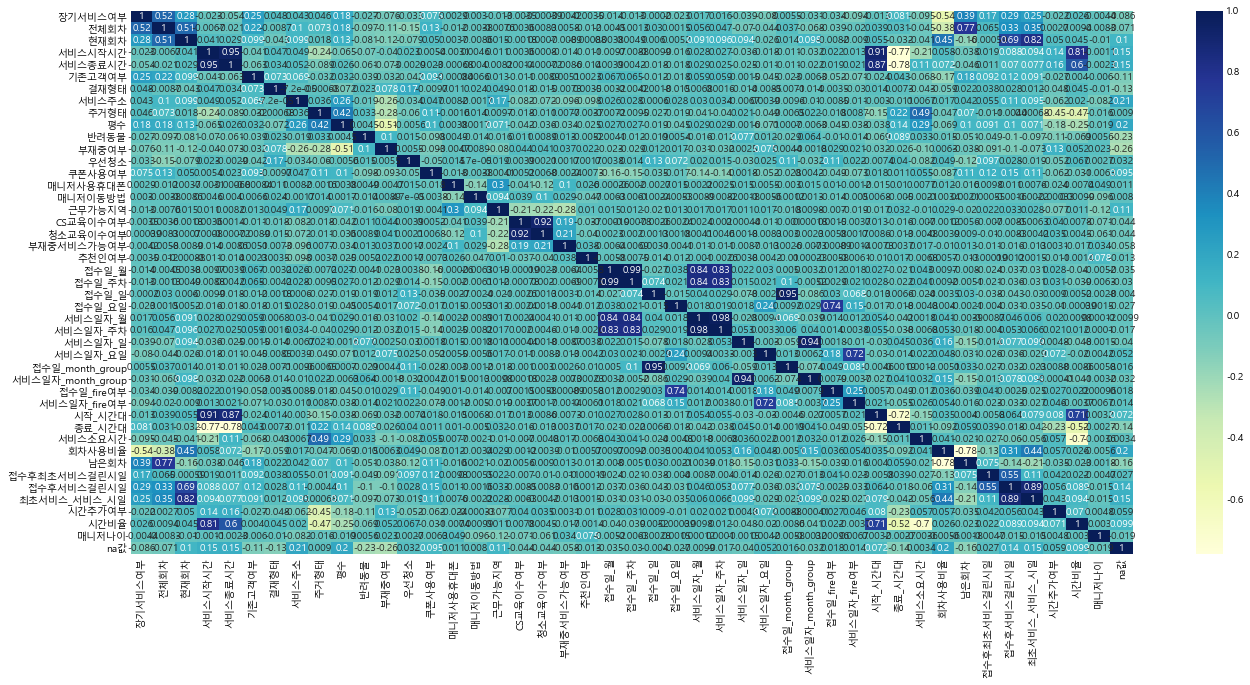

In [44]:
plt.figure(figsize=(20, 10))
sns.heatmap(ftr_imputed.corr(), annot=True, cmap="YlGnBu")
plt.show()

## 스케일링

In [45]:
num_features = list(set(ftr.columns) - set(cat_features))

In [46]:
num_features

['시간비율',
 '매니저나이',
 '서비스종료시간',
 '서비스소요시간',
 '현재회차',
 '서비스일자_월',
 '서비스일자_주차',
 '접수일_주차',
 '전체회차',
 '최초서비스_서비스_시일',
 '접수일_일',
 '접수일_월',
 '서비스일자_일',
 '접수후서비스걸린시일',
 '회차사용비율',
 '서비스시작시간',
 '접수후최초서비스걸린시일',
 '남은회차',
 'na값']

### Min-max

In [51]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
ftr_imputed[num_features] = pd.DataFrame(scaler.fit_transform(ftr_imputed[num_features]))
ftr_te_imputed[num_features] = pd.DataFrame(scaler.transform(ftr_te_imputed[num_features]))

ftr_imputed[num_features].columns = ftr[num_features].columns
ftr_te_imputed[num_features].columns = ftr[num_features].columns

### Gauss rank
* https://github.com/aldente0630/gauss_rank_scaler

In [47]:
import numpy as np
from joblib import Parallel, delayed
from scipy.interpolate import interp1d
from scipy.special import erf, erfinv
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import FLOAT_DTYPES, check_array, check_is_fitted

class GaussRankScaler(BaseEstimator, TransformerMixin):
    """Transform features by scaling each feature to a normal distribution.
    Parameters
        ----------
        epsilon : float, optional, default 1e-4
            A small amount added to the lower bound or subtracted
            from the upper bound. This value prevents infinite number
            from occurring when applying the inverse error function.
        copy : boolean, optional, default True
            If False, try to avoid a copy and do inplace scaling instead.
            This is not guaranteed to always work inplace; e.g. if the data is
            not a NumPy array, a copy may still be returned.
        n_jobs : int or None, optional, default None
            Number of jobs to run in parallel.
            ``None`` means 1 and ``-1`` means using all processors.
        interp_kind : str or int, optional, default 'linear'
           Specifies the kind of interpolation as a string
            ('linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic',
            'previous', 'next', where 'zero', 'slinear', 'quadratic' and 'cubic'
            refer to a spline interpolation of zeroth, first, second or third
            order; 'previous' and 'next' simply return the previous or next value
            of the point) or as an integer specifying the order of the spline
            interpolator to use.
        interp_copy : bool, optional, default False
            If True, the interpolation function makes internal copies of x and y.
            If False, references to `x` and `y` are used.
        Attributes
        ----------
        interp_func_ : list
            The interpolation function for each feature in the training set.
        """

    def __init__(self, epsilon=1e-4, copy=True, n_jobs=None, interp_kind='linear', interp_copy=False):
        self.epsilon = epsilon
        self.copy = copy
        self.interp_kind = interp_kind
        self.interp_copy = interp_copy
        self.fill_value = 'extrapolate'
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        """Fit interpolation function to link rank with original data for future scaling
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The data used to fit interpolation function for later scaling along the features axis.
        y
            Ignored
        """
        X = check_array(X, copy=self.copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        self.interp_func_ = Parallel(n_jobs=self.n_jobs)(delayed(self._fit)(x) for x in X.T)
        return self

    def _fit(self, x):
        x = self.drop_duplicates(x)
        rank = np.argsort(np.argsort(x))
        bound = 1.0 - self.epsilon
        factor = np.max(rank) / 2.0 * bound
        scaled_rank = np.clip(rank / factor - bound, -bound, bound)
        return interp1d(
            x, scaled_rank, kind=self.interp_kind, copy=self.interp_copy, fill_value=self.fill_value)

    def transform(self, X, copy=None):
        """Scale the data with the Gauss Rank algorithm
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The data used to scale along the features axis.
        copy : bool, optional (default: None)
            Copy the input X or not.
        """
        check_is_fitted(self, 'interp_func_')

        copy = copy if copy is not None else self.copy
        X = check_array(X, copy=copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        X = np.array(Parallel(n_jobs=self.n_jobs)(delayed(self._transform)(i, x) for i, x in enumerate(X.T))).T
        return X

    def _transform(self, i, x):
        return erfinv(self.interp_func_[i](x))

    def inverse_transform(self, X, copy=None):
        """Scale back the data to the original representation
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data used to scale along the features axis.
        copy : bool, optional (default: None)
            Copy the input X or not.
        """
        check_is_fitted(self, 'interp_func_')

        copy = copy if copy is not None else self.copy
        X = check_array(X, copy=copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        X = np.array(Parallel(n_jobs=self.n_jobs)(delayed(self._inverse_transform)(i, x) for i, x in enumerate(X.T))).T
        return X

    def _inverse_transform(self, i, x):
        inv_interp_func = interp1d(self.interp_func_[i].y, self.interp_func_[i].x, kind=self.interp_kind,
                                   copy=self.interp_copy, fill_value=self.fill_value)
        return inv_interp_func(erf(x))

    @staticmethod
    def drop_duplicates(x):
        is_unique = np.zeros_like(x, dtype=bool)
        is_unique[np.unique(x, return_index=True)[1]] = True
        return x[is_unique]

In [48]:
scaler = GaussRankScaler()
ftr_imputed[num_features] = pd.DataFrame(scaler.fit_transform(ftr_imputed[num_features]))
ftr_te_imputed[num_features] = pd.DataFrame(scaler.transform(ftr_te_imputed[num_features]))

ftr_imputed[num_features].columns = ftr[num_features].columns
ftr_te_imputed[num_features].columns = ftr[num_features].columns

In [49]:
ftr_imputed.head()

,장기서비스여부,전체회차,현재회차,서비스시작시간,서비스종료시간,기존고객여부,결재형태,서비스주소,주거형태,평수,...,서비스소요시간,회차사용비율,남은회차,접수후최초서비스걸린시일,접수후서비스걸린시일,최초서비스_서비스_시일,시간추가여부,시간비율,매니저나이,na값
0,1.0,-0.594939,-0.540560,-0.427342,-0.355090,1.0,1.0,6.0,1.0,3.0,...,-0.304408,2.751064,-2.751064,-0.547017,-0.433881,-0.456364,0.0,-0.323588,0.956422,2.751064
1,1.0,-0.370644,-0.540560,-0.246445,0.068462,1.0,1.0,6.0,1.0,3.0,...,0.304797,0.477214,-0.943858,-0.743857,-0.029707,0.269150,0.0,-0.741649,-0.323588,0.304797
2,1.0,0.906758,0.098979,-0.427342,-0.355090,1.0,2.0,6.0,1.0,3.0,...,-0.304408,0.167927,-0.246445,-0.607350,-0.363807,-0.304408,0.0,-0.323588,0.000177,-0.304408
3,1.0,-0.370644,-0.304408,-0.427342,-0.207288,1.0,1.0,5.0,1.0,2.0,...,0.000177,2.751064,-2.751064,-1.026835,-0.410081,-0.199393,1.0,-0.656647,0.956422,-2.751064
4,1.0,-0.905952,-0.862895,-0.427342,-0.355090,1.0,1.0,6.0,1.0,3.0,...,-0.304408,2.751064,-2.751064,0.607863,0.030062,-0.797507,0.0,-0.323588,0.211849,2.751064


## 차원축소

In [89]:
ftr.columns

Index(['장기서비스여부', '전체회차', '현재회차', '기존고객여부', '결재형태', '서비스주소', '주거형태', '평수',
       '반려동물', '부재중여부', '우선청소', '쿠폰사용여부', '매니저사용휴대폰', '매니저이동방법', '근무가능지역',
       'CS교육이수여부', '청소교육이수여부', '부재중서비스가능여부', '추천인여부', '서비스시작시간2', '서비스종료시간2',
       '서비스소요시간', '회차사용비율', '접수후최초서비스걸린시일', '접수후서비스걸린시일', '최초서비스_서비스_시일',
       '시간추가여부', '매니저나이', 'na값'],
      dtype='object')

## Embedding

### fasttext

In [296]:
ftr_imputed['서비스특징'] = ftr_imputed['결재형태'].astype(str) + '_' + ftr_imputed['서비스주소'].astype(str) + '_' + ftr_imputed['주거형태'].astype(str) + '_' + ftr_imputed['평수'].astype(str) + '_' \
+ ftr_imputed['우선청소'].astype(str) + '_' + ftr_imputed['매니저사용휴대폰'].astype(str) + '_' +  ftr_imputed['매니저이동방법'].astype(str) + '_' \
+ ftr_imputed['근무가능지역'].astype(str)

ftr_te_imputed['서비스특징'] = ftr_te_imputed['결재형태'].astype(str) + '_' + ftr_te_imputed['서비스주소'].astype(str) + '_' + ftr_te_imputed['주거형태'].astype(str) + '_' + ftr_te_imputed['평수'].astype(str) + '_' \
+ ftr_te_imputed['우선청소'].astype(str) + '_' + ftr_te_imputed['매니저사용휴대폰'].astype(str) + '_' +  ftr_te_imputed['매니저이동방법'].astype(str) + '_' \
+ ftr_te_imputed['근무가능지역'].astype(str)

In [297]:
import random

train_data = list(ftr_imputed['서비스특징'].unique())
test_data = list(ftr_te_imputed['서비스특징'].unique())

In [298]:
test_data[0]

'2.0_6.0_1.0_3.0_3.0_2.0_0.0_5.0'

In [299]:
from gensim.models.fasttext import FastText

In [300]:
model = FastText(sentences=train_data, size=30, window=5, min_count=1, sg=1)

In [301]:
model.train(sentences=train_data, epochs=5, total_examples=model.corpus_count, 
            total_words=model.corpus_total_words)

In [302]:
train_mean_vector = []
for words in tqdm(train_data):
    tmp = np.zeros(30)
    cnt = 0
    for word in words:
        try:
            tmp += model.wv[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    train_mean_vector.append(tmp)
train_mean_vector = np.array(train_mean_vector)

100%|███████████████████████████████████████████████████████████████████████████| 1861/1861 [00:00<00:00, 10981.69it/s]


In [303]:
test_mean_vector = []
for words in tqdm(test_data):
    tmp = np.zeros(30)
    cnt = 0
    for word in words:
        try:
            tmp += model.wv[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    test_mean_vector.append(tmp)
test_mean_vector = np.array(test_mean_vector)

100%|███████████████████████████████████████████████████████████████████████████| 1177/1177 [00:00<00:00, 10926.12it/s]


In [304]:
train_mean_vector = pd.DataFrame(train_mean_vector)
train_mean_vector.columns = train_mean_vector.columns.astype(str) + "_service"

test_mean_vector = pd.DataFrame(test_mean_vector)
test_mean_vector.columns = test_mean_vector.columns.astype(str) + "_service"

In [305]:
train_mean_vector['서비스특징'] = train_data
test_mean_vector['서비스특징'] = test_data

In [306]:
ftr_imputed = ftr_imputed.merge(train_mean_vector, on='서비스특징', how='left').drop('서비스특징', axis=1)
ftr_te_imputed = ftr_te_imputed.merge(test_mean_vector, on='서비스특징', how='left').drop('서비스특징', axis=1)

In [307]:
ftr_imputed.shape, ftr_te_imputed.shape

((23009, 75), (4244, 75))

## Feature selection

In [50]:
from sklearn.model_selection import StratifiedKFold
skfold = StratifiedKFold(n_splits=5) # 교차검증 시 남녀비율을 맞추기 위해 사용

In [51]:
ftr_imputed[cat_features] = ftr_imputed[cat_features].astype('category')
ftr_te_imputed[cat_features] = ftr_te_imputed[cat_features].astype('category')

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [01:13<00:00,  1.29it/s]

(85, 0.8908543133690083)


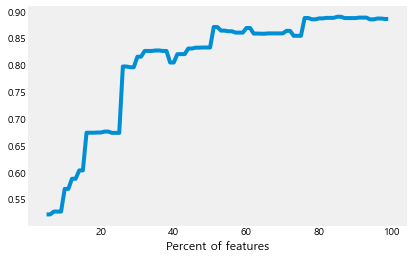

In [54]:
# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model = LGBMClassifier(random_state=0, is_unbalance=True)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = []
for p in tqdm(range(5, 100, 1)):
    X_new = SelectPercentile(percentile=p).fit_transform(ftr_imputed, target) 
    #X_new = RFE(model, n_features_to_select=p, step=10).fit_transform(ftr_imputed, target)
    cv_score = cross_val_score(model, X_new, target, scoring='roc_auc', cv=skfold).mean()
    cv_scores.append((p, cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [55]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
fs = SelectPercentile(percentile=best_score[0]).fit(ftr_imputed, target)
X_train = fs.transform(ftr_imputed)
X_test = fs.transform(ftr_te_imputed)
#fs = RFE(estimator=LGBMClassifier(random_state=0, is_unbalance=True), n_features_to_select=best_score[0], step=10)
#X_train = fs.fit_transform(ftr_imputed, target)
#X_test = fs.transform(ftr_te_imputed)

print(ftr_imputed.shape)
print(ftr_imputed.columns[fs.get_support()].tolist())

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [62]:
ftr_te_imputed

,장기서비스여부,전체회차,현재회차,서비스시작시간,서비스종료시간,기존고객여부,결재형태,서비스주소,주거형태,평수,...,서비스소요시간,회차사용비율,남은회차,접수후최초서비스걸린시일,접수후서비스걸린시일,최초서비스_서비스_시일,시간추가여부,시간비율,매니저나이,na값
0,1.0,0.371051,-0.862895,-0.427342,-0.355090,1.0,2.0,6.0,1.0,3.0,...,-0.304408,-0.476769,0.080928,-0.672468,-0.780325,-1.022260,0.0,-0.323588,0.510484,-2.751064
1,1.0,-0.370644,-2.751064,-0.427342,-0.355090,1.0,2.0,6.0,1.0,3.0,...,-0.304408,-0.476769,-0.427342,-0.242273,-0.647683,-2.751064,0.0,-0.323588,0.510484,-2.751064
2,1.0,-0.178979,-2.751064,-0.427342,-0.355090,1.0,2.0,6.0,1.0,4.0,...,-0.304408,-0.627127,-0.246445,-0.490426,-0.818047,-2.751064,0.0,-0.323588,0.052361,0.304797
3,1.0,-0.370644,-0.540560,-0.427342,-0.355090,1.0,2.0,6.0,1.0,3.0,...,-0.304408,0.477214,-0.943858,-0.490426,-0.254156,-0.199393,0.0,-0.323588,0.510484,-2.751064
4,1.0,-0.594939,-2.751064,-0.427342,-0.355090,1.0,2.0,6.0,1.0,4.0,...,-0.304408,-0.284272,-0.642194,-0.490426,-0.818047,-2.751064,0.0,-0.323588,0.323982,0.304797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4239,1.0,0.371051,-2.751064,-0.427342,-0.355090,1.0,2.0,6.0,1.0,3.0,...,-0.304408,-0.931724,0.246822,-0.490426,-0.818047,-2.751064,0.0,-0.323588,0.510484,-2.751064
4240,1.0,-0.370644,-2.751064,0.427768,0.355492,0.0,1.0,6.0,1.0,4.0,...,-0.304408,-0.476769,-0.427342,-0.547017,-0.858254,-2.751064,0.0,0.211849,-0.323588,0.304797
4241,1.0,-0.370644,-2.751064,-0.427342,-0.355090,1.0,2.0,6.0,1.0,3.0,...,-0.304408,-0.476769,-0.427342,-0.490426,-0.818047,-2.751064,0.0,-0.323588,0.510484,-2.751064
4242,1.0,0.371051,0.098979,-0.427342,-0.355090,1.0,1.0,6.0,1.0,4.0,...,-0.304408,0.477214,-0.642194,-0.490426,0.171129,0.456801,0.0,-0.323588,0.323982,0.304797


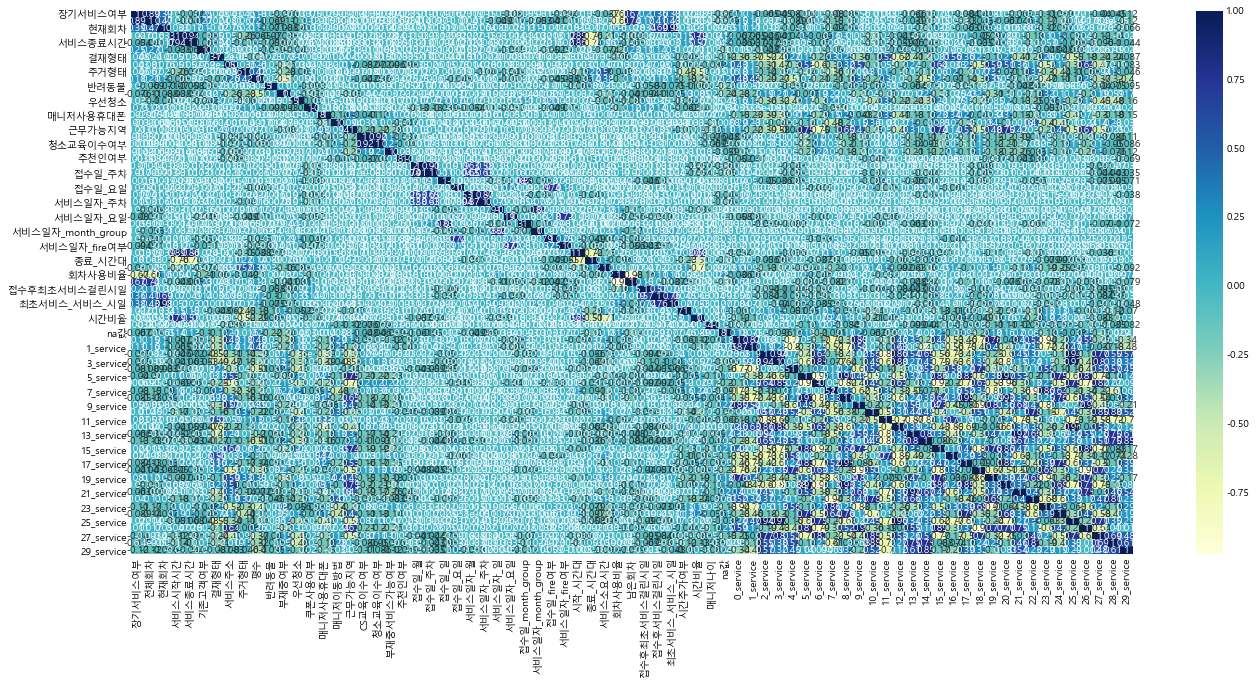

In [230]:
plt.figure(figsize=(20, 10))
sns.heatmap(ftr_imputed.corr(), annot=True, cmap="YlGnBu")
plt.show()

## 샘플링(아마 안하는게 좋지 않을까 싶음)

### over sampling

In [73]:
from imblearn.over_sampling import SMOTE

In [74]:
# SMOTE
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(ftr_imputed, target)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', ftr_imputed.shape, target.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (23009, 30) (23009,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (41622, 30) (41622,)
SMOTE 적용 후 레이블 값 분포: 
 0    20811
1    20811
Name: 매칭성공여부, dtype: int64


In [79]:
ftr_imputed = X_train_over
target = y_train_over

In [34]:
# 문제는 특이 치에있을 수 있습니다. 앞서 언급했듯이 ADASYN은 밀도가 낮은 밀도 데이터에 중점을 둡니다. 
# 종종 저밀도 데이터는 특이 치입니다. 그런 다음 ADASYN 접근 방식은 피쳐 공간의 이러한 영역에 너무 많은주의를 기울여 
# 모델 성능을 저하시킬 수 있습니다. ADASYN을 사용하기 전에 이상 값을 제거하는 것이 좋습니다.
from imblearn.over_sampling import *
X_samp, y_samp = ADASYN(random_state=0, sampling_strategy='minority').fit_sample(ftr_imputed, target)

In [35]:
X_samp.shape, y_samp.shape

((41204, 30), (41204,))

### combine sampling

## 모델링

In [53]:
from lightgbm import LGBMClassifier
from xgboost import XGBRFClassifier
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from ngboost import NGBRegressor
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score

In [215]:
kf = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)

In [210]:
cat_features = ['장기서비스여부', '기존고객여부', '결재형태', '서비스주소', '주거형태', '평수', '반려동물', '부재중여부', 
                '우선청소', '쿠폰사용여부', '매니저사용휴대폰', '매니저이동방법', '근무가능지역', 'CS교육이수여부', 
                '청소교육이수여부', '부재중서비스가능여부', '추천인여부', '접수일_요일', '서비스일자_요일', '접수일_month_group', 
                '서비스일자_month_group', '접수일_fire여부', '서비스일자_fire여부', '시작_시간대', '종료_시간대',
                '시간추가여부']

In [211]:
ftr_imputed.shape, target.shape, ftr_te_imputed.shape

((23009, 75), (23009,), (4244, 75))

### Catboost

In [216]:
ftr_imputed[cat_features] = ftr_imputed[cat_features].astype(int)
ftr_te_imputed[cat_features] = ftr_te_imputed[cat_features].astype(int)

In [217]:
# catboost data imbalance cover
from sklearn.utils.class_weight import compute_class_weight
 
classes = np.unique(target)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=target)
class_weights = dict(zip(classes, weights))

In [218]:
class_weights

{0: 0.5528086108308107, 1: 5.234076433121019}

In [219]:
cb_pred = np.zeros((ftr_te.shape[0]))
auc_list = []
for tr_idx, val_idx in kf.split(ftr_imputed, target):
    tr_x, val_x = ftr_imputed.iloc[tr_idx], ftr_imputed.iloc[val_idx]
    tr_y, val_y = target.iloc[tr_idx], target.iloc[val_idx]
    train_data = Pool(data=tr_x, label=tr_y, cat_features=cat_features)
    val_data = Pool(data=val_x, label=val_y, cat_features=cat_features)
    cb = CatBoostClassifier(iterations=10000, learning_rate=0.01, eval_metric='AUC', class_weights=class_weights,
                        silent=True, loss_function='Logloss')
    cb.fit(train_data, eval_set=val_data, early_stopping_rounds=1000, use_best_model=True, verbose=2000)
    best = cb.best_iteration_
    pred = cb.predict_proba(val_x, ntree_end=best)[:, 1]
    auc = roc_auc_score(val_y, pred)
    auc_list.append(auc)
    print(f'FOLD ROC-AUC = {auc}')
    sub_pred = cb.predict_proba(ftr_te_imputed, ntree_end=best)[:, 1] / 3
    cb_pred += sub_pred
print(f'\n{cb.__class__.__name__} ROC_AUC_score = {np.mean(auc_list)}')

0:	test: 0.6496121	best: 0.6496121 (0)	total: 227ms	remaining: 37m 49s
2000:	test: 0.8968360	best: 0.8968633 (1998)	total: 1m 42s	remaining: 6m 50s
4000:	test: 0.9144663	best: 0.9144700 (3999)	total: 3m 14s	remaining: 4m 51s
6000:	test: 0.9175950	best: 0.9176027 (5996)	total: 5m 13s	remaining: 3m 29s
8000:	test: 0.9192016	best: 0.9192085 (7994)	total: 7m 9s	remaining: 1m 47s
9999:	test: 0.9207033	best: 0.9207033 (9999)	total: 9m 5s	remaining: 0us

bestTest = 0.920703305
bestIteration = 9999

FOLD ROC-AUC = 0.9207003550370801
0:	test: 0.6491751	best: 0.6491751 (0)	total: 45.2ms	remaining: 7m 31s
2000:	test: 0.8920359	best: 0.8921099 (1988)	total: 1m 49s	remaining: 7m 18s
4000:	test: 0.9086489	best: 0.9087152 (3964)	total: 3m 43s	remaining: 5m 34s
6000:	test: 0.9132186	best: 0.9137629 (5666)	total: 5m 40s	remaining: 3m 46s
8000:	test: 0.9162557	best: 0.9162688 (7888)	total: 7m 37s	remaining: 1m 54s
9999:	test: 0.9182441	best: 0.9182532 (9976)	total: 9m 36s	remaining: 0us

bestTest = 0.91

In [220]:
cb_pred.shape

(4244,)

In [221]:
cb_pred

array([3.40430962e-04, 7.38312435e-02, 6.55786392e-02, ...,
       2.90397751e-01, 3.01501149e-04, 3.07537511e-01])

### TabNet

In [101]:
ftr[cat_features] = ftr[cat_features].astype(str)
ftr_te[cat_features] = ftr_te[cat_features].astype(str)

In [102]:
if "Set" not in ftr.columns:
    ftr["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(ftr.shape[0],))

train_indices = ftr[ftr.Set=="train"].index
valid_indices = ftr[ftr.Set=="valid"].index
test_indices = ftr[ftr.Set=="test"].index

In [103]:
import os
import torch
import torch.nn as nn
from pytorch_tabnet.tab_model import TabNetClassifier

In [104]:
nunique = ftr.nunique()
types = ftr.dtypes

categorical_columns = []
categorical_dims =  {}
for col in ftr.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, ftr[col].nunique())
        l_enc = LabelEncoder()
        ftr[col] = ftr[col].fillna("VV_likely")
        ftr[col] = l_enc.fit_transform(ftr[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        ftr.fillna(ftr.loc[train_indices, col].mean(), inplace=True)

장기서비스여부 2
전체회차 11
현재회차 10
기존고객여부 2
결재형태 4
서비스주소 42
주거형태 2
평수 5
부재중여부 3
우선청소 6
쿠폰사용여부 2
매니저사용휴대폰 4
매니저이동방법 3
근무가능지역 8
CS교육이수여부 3
청소교육이수여부 3
부재중서비스가능여부 2
추천인여부 2
서비스시작시간2 12
서비스종료시간2 14
서비스소요시간 7
회차사용비율 33
접수후최초서비스걸린시일 42
접수후서비스걸린시일 90
최초서비스_서비스_시일 55
시간추가여부 2
매니저나이 35
na값 4
반려동물_고양이 2
반려동물_개 2
반려동물_기타 2
반려동물_없음 2
Set 3


In [106]:
# Contains dimension and idxs of categorical variable for categorical embedding.
unused_feat = ['Set']
features = [ col for col in ftr.columns if col not in unused_feat] 
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [107]:
from tqdm import tqdm
features = ftr_te.columns.tolist()
len(features)

for col in tqdm(features):
    ftr_te[col+'_bin'] = ftr_te[col].apply(lambda x: 1 if np.cbrt(x)>0 else 0)

print(f"test_df: {ftr_te.shape}")
ftr_te.head(20)

  0%|                                                                                           | 0/32 [00:00<?, ?it/s]


TypeError: ufunc 'cbrt' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [108]:
nunique = ftr_te.nunique()
types = ftr_te.dtypes

categorical_columns = []
categorical_dims =  {}
for col in ftr_te.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, ftr_te[col].nunique())
        l_enc = LabelEncoder()
        ftr_te[col] = ftr_te[col].fillna("VV_likely")
        ftr_te[col] = l_enc.fit_transform(ftr_te[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        ftr_te.fillna(ftr_te.loc[test_indices, col].mean(), inplace=True)

장기서비스여부 2
전체회차 11
현재회차 10
기존고객여부 2
결재형태 4
서비스주소 47
주거형태 2
평수 5
부재중여부 3
우선청소 6
쿠폰사용여부 2
매니저사용휴대폰 4
매니저이동방법 3
근무가능지역 8
CS교육이수여부 3
청소교육이수여부 3
부재중서비스가능여부 2
추천인여부 2
서비스시작시간2 11
서비스종료시간2 11
서비스소요시간 7
회차사용비율 33
접수후최초서비스걸린시일 42
접수후서비스걸린시일 88
최초서비스_서비스_시일 54
시간추가여부 2
매니저나이 35
na값 5
반려동물_고양이 2
반려동물_개 2
반려동물_기타 2
반려동물_없음 2


In [109]:
# Contains dimension and idxs of categorical variable for categorical embedding.
unused_feat = ['Set']
features = [ col for col in ftr_te.columns if col not in unused_feat] 
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [110]:
clf = TabNetClassifier(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=10,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=1e-2),
                       scheduler_params={"step_size":50,
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax' # "sparsemax", entmax
                      )

Device used : cuda


In [125]:
X_train = ftr.iloc[train_indices].reset_index(drop=True)
X_valid = ftr.iloc[valid_indices].reset_index(drop=True)
y_train = target[train_indices].reset_index(drop=True)
y_valid = target[valid_indices].reset_index(drop=True)

In [126]:
X_train

,장기서비스여부,전체회차,현재회차,기존고객여부,결재형태,서비스주소,주거형태,평수,부재중여부,우선청소,쿠폰사용여부,매니저사용휴대폰,매니저이동방법,근무가능지역,CS교육이수여부,청소교육이수여부,부재중서비스가능여부,추천인여부,서비스시작시간2,서비스종료시간2,서비스소요시간,회차사용비율,접수후최초서비스걸린시일,접수후서비스걸린시일,최초서비스_서비스_시일,시간추가여부,매니저나이,na값,반려동물_고양이,반려동물_개,반려동물_기타,반려동물_없음,Set
0,1,2,2,1,1,41,1,4,2,0,0,3,1,3,0,0,1,0,3,4,2,32,9,24,14,0,31,3,0,0,0,0,1
1,1,3,2,1,1,41,1,4,2,0,0,3,1,6,1,1,1,0,4,7,4,24,6,43,35,0,11,2,0,0,0,1,1
2,1,9,5,1,3,41,1,3,0,0,0,3,1,6,0,0,0,0,3,4,2,19,8,27,18,0,17,1,0,0,0,1,1
3,1,3,3,1,1,21,1,2,0,2,0,3,1,3,0,0,1,0,3,5,3,32,3,25,21,1,31,0,0,0,0,1,1
4,1,7,5,1,1,40,1,4,2,0,0,3,2,6,0,0,1,0,3,4,2,24,17,53,34,0,21,2,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18467,1,4,3,1,0,41,1,3,0,0,0,3,1,2,0,0,1,0,2,4,3,26,18,40,21,1,8,1,0,0,0,1,1
18468,1,3,0,1,3,0,0,1,1,1,0,3,2,6,0,0,1,0,10,9,0,8,4,5,0,0,17,0,1,0,0,0,1
18469,1,9,8,1,3,40,1,4,2,0,1,3,1,6,0,0,1,0,8,9,2,31,30,89,54,0,18,2,0,0,0,1,1
18470,1,3,2,1,3,40,1,4,2,0,0,3,2,6,1,1,1,0,8,9,2,24,5,20,14,0,20,3,0,0,0,0,1


In [128]:
max_epochs = 100

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
)

KeyError: 1658

In [123]:
prediction = clf.predict(X_test)

NameError: name 'X_test' is not defined

## submission

In [226]:
submission['pred'] = cb_pred

In [227]:
#submission['pred'] = submission['pred'].apply(lambda x : 1 if x >= 0.5 else 0)

In [228]:
#submission['pred'].value_counts()

In [225]:
submission = submission.set_index('SEQ')
submission

,pred
SEQ,
T54370,0.000340
T47892,0.073831
T56637,0.065579
T45487,0.002063
T41995,0.057544
...,...
T31589,0.051674
T36236,0.000435
T34729,0.290398


In [229]:
submission.to_csv('submission/1119_cat_gr_ft_3fold_pyeong.csv')